In [1]:
import os

In [22]:
from tqdm import tqdm, tnrange
import shutil
import csv

# Data Loading 

In [3]:
# _Start: create a directory for dataset 
data_root = "../../data"
os.makedirs(data_root, exist_ok = True)
# _End: create a directory for dataset 

In [4]:
# Start: find the class ID for backpacks 
def find_class_id(classname, csv_path='class-descriptions-segmentable.csv'):
    with open(csv_path, 'r') as file: 
        for line in file: 
            cls = line.rstrip().split(",")  #_ for comma separated value(.csv)
            print(cls)
            if classname == cls[1]:
                return cls[0]            
    return None   
# End: find the class ID for backpacks 

class_ds_path = os.path.join(data_root, "class-descriptions-segmentable.csv")
class_name = "Backpack"
backpack_classID = find_class_id(class_name, class_ds_path)
print(f"Class ID of BackPack: {backpack_classID}")

['/m/011k07', 'Tortoise']
['/m/012074', 'Magpie']
['/m/0120dh', 'Sea turtle']
['/m/01226z', 'Football']
['/m/012n7d', 'Ambulance']
['/m/0138tl', 'Toy']
['/m/014j1m', 'Apple']
['/m/01599', 'Beer']
['/m/01_5g', 'Chopsticks']
['/m/015p6', 'Bird']
['/m/015qff', 'Traffic light']
['/m/015wgc', 'Croissant']
['/m/015x4r', 'Cucumber']
['/m/015x5n', 'Radish']
['/m/0162_1', 'Towel']
['/m/016m2d', 'Skull']
['/m/0174k2', 'Washing machine']
['/m/0174n1', 'Glove']
['/m/0176mf', 'Belt']
['/m/018xm', 'Ball']
['/m/01940j', 'Backpack']
Class ID of BackPack: /m/01940j


In [5]:
"a" in "abs"

True

In [6]:
# Start: to select all backpack masks among all the masks in folders, then save them in the other folder 
def copy_mask_for_classid(classid:str, source_dir:str, target_dir:str) -> None: 
    os.makedirs(target_dir, exist_ok=True)
    
    for img_file in os.listdir(source_dir): 
        if classid in img_file: 
            file_path = os.path.join(source_dir, img_file)
            shutil.copy(file_path, target_dir)
            
    return None 
# End: to select all backpack masks among all the masks in folders, then save them in the other folder 

backpack_mask_dir = os.path.join(data_root, "backpack-masks")
dataset_list = ["train-masks-0", "train-masks-1", "train-masks-2", "train-masks-3"]

for i, data_dir in enumerate(dataset_list):
    copy_mask_for_classid(backpack_classID.replace('/',''),os.path.join(data_root, data_dir),backpack_mask_dir)
    

In [7]:
# to get annotations file 
train_seg_csv_path = os.path.join(data_root, 'train-annotations-object-segmentation.csv')

In [40]:
# _Start: get image ID lists from masks 
def get_imageid_from_masks(mask_dir_path:str) -> set: 
    
    IDs_list = os.listdir(mask_dir_path)
    img_ids = [] 
    
    for i, id_name in tqdm(enumerate(IDs_list) ,desc="loading...: "):
        t = id_name.split("_")[0]
        img_ids.append(t)
        
    return set(img_ids)
# _End: get image ID lists from masks 


backpack_id = get_imageid_from_masks(backpack_mask_dir)
#print(backpack_id)

loading...: : 484it [00:00, 407475.54it/s]


In [54]:
# _Start: get class annotations 
def get_class_annotations(classes_list: str, class_ds_csv:str, annotations_csv:str):
    classes = classes_list  # list of selected classes 
    
    # _Start: Crate dict with className to classID mapping 
    with open(class_ds_csv, mode='r') as file: 
        reader = csv.reader(file)
        dict_list = {rows[1]:rows[0] for rows in reader}
    # _End: Crate dict with className to classID mapping 
    
    with open(annotations_csv, mode='r') as file_ann: 
        classAnnotations_dict = {} 
        
        for idx, val in enumerate(classes): 
            class_name = classes[idx]
            classAnnotations_dict[class_name] = []
            print(f"Class {idx}: {class_name}")
            
            # select the annotations with backpack classID
            for line in file_ann:
                if dict_list[class_name] in line: 
                    classAnnotations_dict[class_name].append(line.rstrip())
                    
    return classAnnotations_dict
# _End: get class annotations 

annotations  = get_class_annotations(['Backpack'], class_ds_path, train_seg_csv_path )
print(f"Total number of annotations: {len(annotations['Backpack'])}")

Class 0: Backpack
Total number of annotations: 1082


In [47]:
annotations['Backpack'][0]

'b341813136daad57_m01940j_c3ffcfe8.png,b341813136daad57,/m/01940j,c3ffcfe8,0.151875,0.786875,0.07016,0.946714,0.87741,0.54364 0.93414 1;0.67057 0.91610 1;0.48364 0.10124 1;0.24019 0.87511 1;0.45352 0.11697 0;0.32710 0.19523 1;0.57368 0.13120 1;0.66130 0.16499 1;0.45018 0.11436 0;0.43864 0.07009 1;0.15826 0.87347 1;0.61634 0.15371 0'

In [56]:
backpack_image_dir = os.path.join(data_root, 'backpack-images')

# Data Preparation for Training 
* We got a total of 329 training RGB images. 
* Data shuold be split into the training and validation set. 
* We need data in the COCO JSON format. 

In [68]:
# _Start: split data into train and validation in a 9:1 ratio
def split_train_validation(data_dir_path:str):
    img_files = os.listdir(data_dir_path)
    train = [] 
    val = [] 
    
    # _Start: split
    for i, img_file in enumerate(img_files):
        if i%10 == 0: 
            val.append(img_file)
            
        else: 
            train.append(img_file)        
    # _End: split 
    
    print(f"Number of training samples: {len(train)} ")
    print(f"Number of validation samples: {len(val)} ")
    
    return train, val 
# _End: split data into train and validation in a 9:1 ratio

train_images, val_images = split_train_validation(data_dir_path= backpack_image_dir)

Number of training samples: 296 
Number of validation samples: 33 


### Generate COCO formatted JSON

```
{
    "images": {"file_name": imageID + ".jpg",
               "height": imageHeight,
               "width": imageWidth,
               "id": imageID
              },
    "categories": { "supercategory": "object",
                    "id": classID,
                    "name": className
                  },
    "annotations": { "segmentation": contourPts,
                     "iscrowd": 0,
                     "image_id": imageID,
                     "bbox": bounding box coordinates(XYWH),
                     "category_id": classID,
                     "id": boxID
                   }
}
```

* ```contourPts``` from mask 
* ```bounding box coordinates(XYWH)``` from annotations

In [59]:
from collections import defaultdict

def get_annotations_for_each_image(annotations, mask_dir_path, class_name, class_index): 
    
    class_annotations = annotations[class_name]
    annotations_count = len(class_annotations)
    image_id_set = get_imageid_from_masks(mask_dir_path)
    
    boxes = defaultdict(list) 
    
    for i, line in enumerate(class_annotations[:annotations_count]):
        line_parts = line.split(',')  # .csv 
        
        # select annotations from t hose images whose masks we have downloaded 
        if line_parts[1] not in image_id_set:   # If 'ImageID' is not in image_id_set
            continue 
            
        mask_path = line_parts[0]  
        image_id  = line_parts[1] 
        
        xmin = line_parts[4]
        xmax = line_parts[5]
        ymin = line_parts[6]
        ymax = line_parts[7]
        bbox_id = line_parts[3]
        
        # Start: store annotations per image based on imageID 
        dic = {
            'mask_path': mask_path,
            'class' : str(class_index),
            'bbox'  : [xmin, xmax, ymin, ymax],
            'box_id': bbox_id
        }
        
        boxes[image_id].append(dic)
        
    return boxes

In [60]:
backpack_boxes = get_annotations_for_each_image(annotations, backpack_mask_dir, 'Backpack', 1 )

loading...: : 484it [00:00, 459493.69it/s]


In [61]:
backpack_boxes

defaultdict(list,
            {'04feb4c5056e2f7e': [{'mask_path': '04feb4c5056e2f7e_m01940j_f7c7ac22.png',
               'class': '1',
               'bbox': ['0.429375', '0.685', '0.312556', '0.877115'],
               'box_id': 'f7c7ac22'}],
             '0070763c2177cfd0': [{'mask_path': '0070763c2177cfd0_m01940j_79b93825.png',
               'class': '1',
               'bbox': ['0.20625', '0.351875', '0.189493', '0.292683'],
               'box_id': '79b93825'},
              {'mask_path': '0070763c2177cfd0_m01940j_f084349f.png',
               'class': '1',
               'bbox': ['0.340625', '0.440625', '0.238274', '0.34803'],
               'box_id': 'f084349f'}],
             '045745b2dc1908d3': [{'mask_path': '045745b2dc1908d3_m01940j_fd46add0.png',
               'class': '1',
               'bbox': ['0.614375', '0.675', '0.639167', '0.739167'],
               'box_id': 'fd46add0'},
              {'mask_path': '045745b2dc1908d3_m01940j_f93980c7.png',
               'class':

### Contour Calculation 

In [86]:
import cv2

def get_contour_pts(mask_path, width, height):
    
    # 0 is used to read image in gray scale mode
    mask = cv2.imread(mask_path, 0)
    
    if mask is None:
        print("No image")
        
    
    mask_img = cv2.resize(mask, (width, height), cv2.INTER_NEAREST)
    ret, thresh = cv2.threshold(mask_img, 127, 255, 0)
    _, orig_contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1)
        
    sorted_contours = []
    cnt_area = []

    for cnt in orig_contours:
        if len(cnt.shape) == 3 and cnt.shape[1] == 1:
            cnt_area.append(cv2.contourArea(cnt))
            sorted_contours.append(cnt.reshape(-1).tolist())

    contour = [p for p in sorted_contours if len(p) > 4]
    area = [cnt_area[i] for i,p in enumerate(sorted_contours) if len(p) > 4]
    
    return (contour, area)

#### Generate ```train.json``` and ```validation.json```.

In [87]:
import json

def generate_COCO_formatted_json(boxes, mask_dir, image_dir, image_list, json_filepath):
    annotations = []
    images = []
    categories = []

    for img_id, img_meta_list in boxes.items():
        
        image_filename = '{}.jpg'.format(img_id)
        
        if image_filename not in image_list:
            continue
            
        img_path = os.path.join(image_dir, image_filename)

        img = cv2.imread(img_path)
        h, w, _ = img.shape

        for index, img_meta in enumerate(img_meta_list):
            class_id = img_meta["class"]
            xp1, xp2, yp1, yp2 = img_meta["bbox"]
            x1, x2, y1, y2 = float(xp1)*w, float(xp2)*w, float(yp1)*h, float(yp2)*h
            
            mask_path = os.path.join(mask_dir, img_meta["mask_path"])

            contour, area = get_contour_pts(mask_path, w, h)        

            if not contour:
                continue

            bbox_coord = [int(x1), int(y1), int(x2) - int(x1), int(y2) - int(y1)]

            annotations.append({
                "segmentation": contour,
                "iscrowd": 0,
                "image_id": img_id,
                "bbox": bbox_coord,
                "area": area[0],
                "category_id": class_id,
                "id": img_meta["box_id"]})


        images.append({"file_name": img_id + ".jpg",
            "height": h,
            "width": w,
            "id": img_id})


    categories.append({"supercategory": "object", "id": class_id, "name": "backpack"})


    with open(json_filepath, "w") as f:
        json.dump({"images": images, "annotations": annotations, "categories": categories}, f)
        
    return

In [88]:
train_json_path = os.path.join(data_root, 'train.json')
validation_json_path = os.path.join(data_root, 'validation.json')

# Get train.json in coco format

generate_COCO_formatted_json(boxes=backpack_boxes, 
                             mask_dir=backpack_mask_dir, 
                             image_dir=backpack_image_dir, 
                             image_list=train_images, 
                             json_filepath=train_json_path)

# Get validation.json in coco format

generate_COCO_formatted_json(boxes=backpack_boxes, 
                             mask_dir=backpack_mask_dir, 
                             image_dir=backpack_image_dir, 
                             image_list=val_images, 
                             json_filepath=validation_json_path)

# Train using Detectron2

In [89]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

<Logger detectron2 (DEBUG)>

In [91]:
# import some common detectron2 utilities

# model_zoo has a lots of pre-trained model
from detectron2 import model_zoo

# DefaultTrainer is a class for training instance segmentation model and inference
from detectron2.engine import DefaultTrainer, DefaultPredictor

# detectron2 has its configuration format
from detectron2.config import get_cfg

# detectron2 has implemented Visualizer of object detection
from detectron2.utils.visualizer import Visualizer, ColorMode

# from DatasetCatalog, detectron2 gets dataset and from MetadatCatalog it gets metadata of the dataset
from detectron2.data import DatasetCatalog, MetadataCatalog

# Registers COCO format datasets
from detectron2.data.datasets import register_coco_instances

# COCOEvaluator based on COCO evaluation metric, inference_on_dataset is used for evaluation for a given metric
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

# build_detection_test_loader, used to create test loader for evaluation
from detectron2.data import build_detection_test_loader

In [90]:
# import some common libraries
import numpy as np
import cv2
import random
import os
import json
import matplotlib.pyplot as plt

### Register Dataset 
* As the dataset is already in COCO format, we can use the following method 
    > ```register_coco_instances(name, metadata, json_file, image_root)```

* This method internally class <b>load_coco_json</b> method, registers dataset and also adds metadata.

In [92]:
train_data_name = 'backpack_train'
val_data_name = 'backpack_val'

register_coco_instances(train_data_name, {}, train_json_path, backpack_image_dir)
register_coco_instances(val_data_name, {}, validation_json_path, backpack_image_dir)

WARNING [05/27 14:16:58 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/27 14:16:58 d2.data.datasets.coco]: Loaded 260 images in COCO format from ../../data/train.json


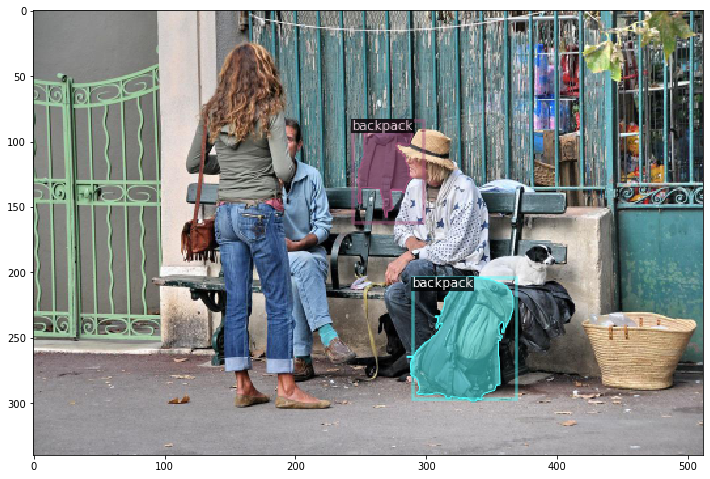

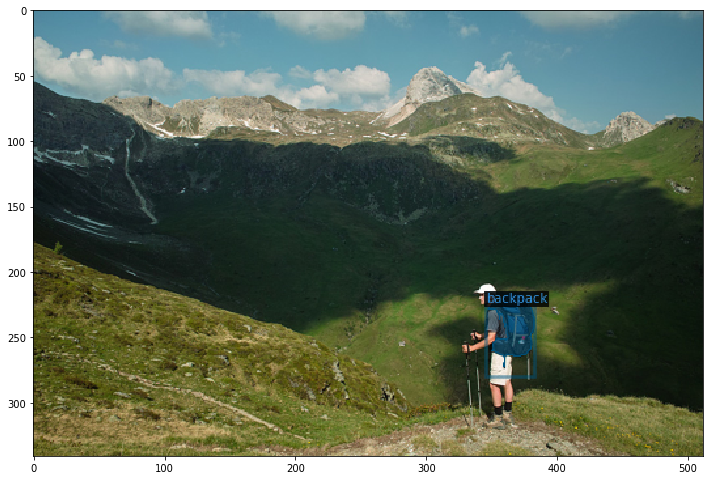

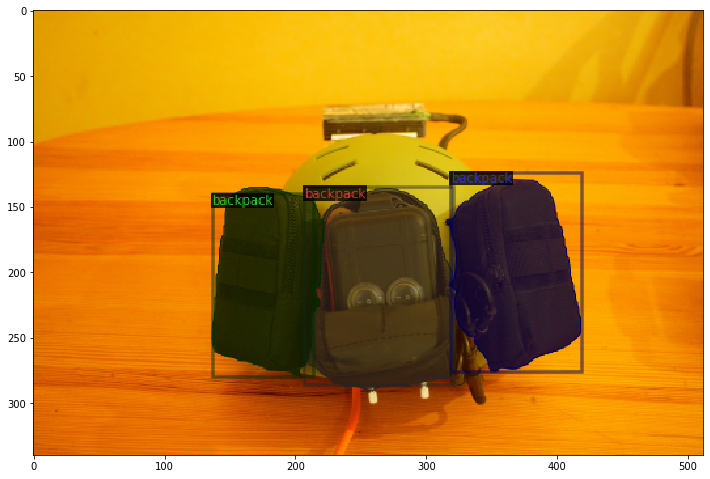

In [93]:
backpack_train_metadata = MetadataCatalog.get(train_data_name)

dataset_dicts = DatasetCatalog.get(name=train_data_name)

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=backpack_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize = (12, 12))
    plt.imshow(vis.get_image())
    plt.show()

## Set Config and Import model files 
Get default configuration of detectron2 and update parameters according to our requirements.

Get more details of the configuration <a  href="https://detectron2.readthedocs.io/modules/config.html#">here</a>.

In [94]:
#Initialize with default configuration
cfg = get_cfg()

# update configuration with MaskRCNN configuration
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

# Let's replace the detectron2 default train dataset with our train dataset.
cfg.DATASETS.TRAIN = (train_data_name,)

# No metric implemented for the test dataset, we will have to update cfg.DATASET.TEST with empty tuple
cfg.DATASETS.TEST = ()

# data loader configuration
cfg.DATALOADER.NUM_WORKERS = 2

# Update model URL in detectron2 config file
# Let training initialize from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  

# batch size
cfg.SOLVER.IMS_PER_BATCH = 2

# choose a good learning rate
cfg.SOLVER.BASE_LR = 0.0005

# We need to specify the number of iteration for training in detectron2, not the number of epochs.
cfg.SOLVER.MAX_ITER = 500
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128

# number of output class
# we have only one class that is Backpack
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

## Training 

In [97]:
# update create ouptput directory 
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [98]:
# training

# Create a trainer instance with the configuration.
trainer = DefaultTrainer(cfg) 

# if resume=False, because we don't have trained model yet. It will download model from model url and load it
trainer.resume_or_load(resume=False)

# start training
trainer.train()

[05/27 14:24:59 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

WARNING [05/27 14:24:59 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/27 14:24:59 d2.data.datasets.coco]: Loaded 260 images in COCO format from ../../data/train.json
[05/27 14:24:59 d2.data.build]: Removed 0 images with no usable annotations. 260 images left.
[05/27 14:24:59 d2.data.common]: Serializing 260 elements to byte tensors and concatenating them all ...
[05/27 14:24:59 d2.data.common]: Serialized dataset takes 0.57 MiB
[05/27 14:24:59 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[05/27 14:24:59 d2.data.build]: Using training sampler TrainingSampler


'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (2, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (2,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (4, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (4,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (80,) in the checkpoint but (1,) in the model! Skipped.


[05/27 14:25:00 d2.engine.train_loop]: Starting training from iteration 0
[05/27 14:25:05 d2.utils.events]:  eta: 0:02:02  iter: 19  total_loss: 2.206  loss_cls: 0.752  loss_box_reg: 0.775  loss_mask: 0.692  loss_rpn_cls: 0.018  loss_rpn_loc: 0.008  time: 0.2555  data_time: 0.0145  lr: 0.000010  max_mem: 2759M
[05/27 14:25:10 d2.utils.events]:  eta: 0:01:56  iter: 39  total_loss: 2.055  loss_cls: 0.680  loss_box_reg: 0.645  loss_mask: 0.683  loss_rpn_cls: 0.019  loss_rpn_loc: 0.012  time: 0.2561  data_time: 0.0058  lr: 0.000020  max_mem: 2759M
[05/27 14:25:15 d2.utils.events]:  eta: 0:01:51  iter: 59  total_loss: 1.865  loss_cls: 0.550  loss_box_reg: 0.624  loss_mask: 0.650  loss_rpn_cls: 0.013  loss_rpn_loc: 0.008  time: 0.2542  data_time: 0.0056  lr: 0.000030  max_mem: 2759M
[05/27 14:25:20 d2.utils.events]:  eta: 0:01:46  iter: 79  total_loss: 1.750  loss_cls: 0.462  loss_box_reg: 0.631  loss_mask: 0.606  loss_rpn_cls: 0.014  loss_rpn_loc: 0.009  time: 0.2528  data_time: 0.0054  lr:

## Inference using the trained model 

In [101]:
# inference on our fine-tuned model

# By default detectron2 save the model with name model_final.pth
# update the model path in configuration that will be used to load the model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

# set the testing threshold for this model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9


cfg.DATASETS.TEST = (val_data_name,)

backpack_test_metadata = MetadataCatalog.get(val_data_name)

# create a predictor instance with the configuration (it has our fine-tuned model)
# this predictor does prdiction on a single image
predictor = DefaultPredictor(cfg)

WARNING [05/27 14:30:52 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/27 14:30:52 d2.data.datasets.coco]: Loaded 29 images in COCO format from ../../data/validation.json
../../data/backpack-images/1209e7ce038f6790.jpg


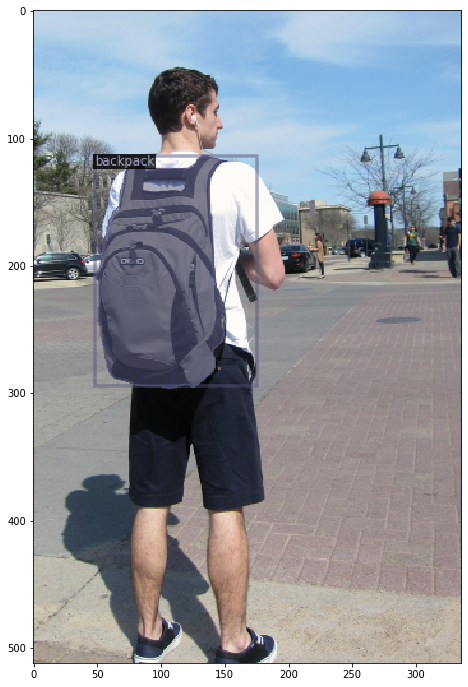

../../data/backpack-images/00313c9daa6289ec.jpg


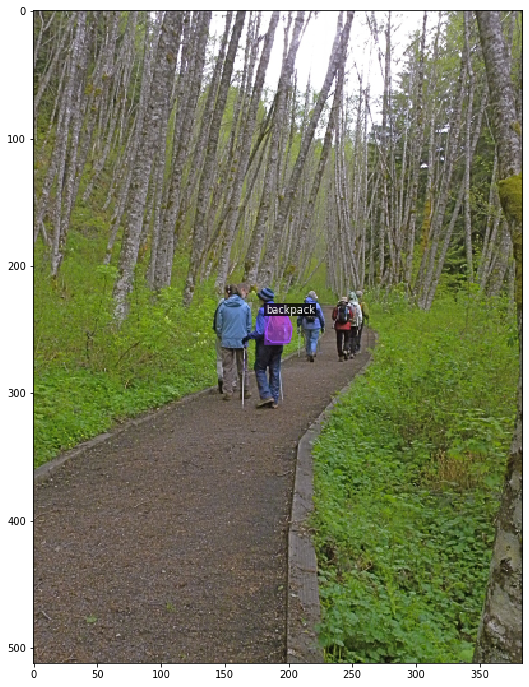

../../data/backpack-images/27da06478e666863.jpg


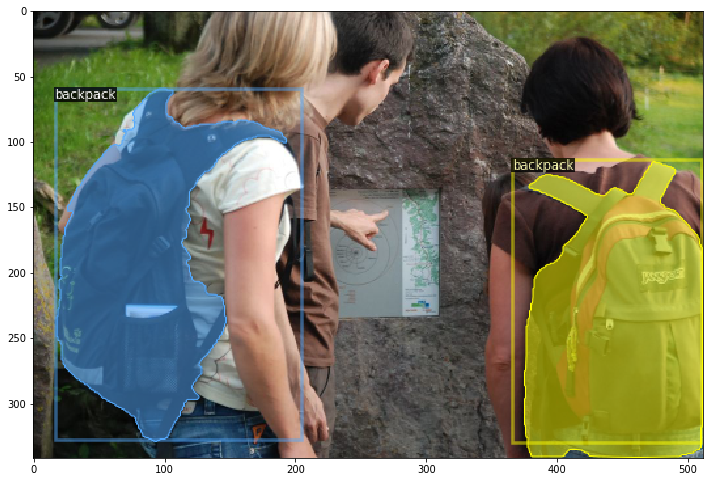

In [102]:
# let's have a look on prediction
test_dataset_dicts = DatasetCatalog.get(val_data_name)

for d in random.sample(test_dataset_dicts, 3):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=backpack_test_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize = (12, 12))
    plt.imshow(vis.get_image())
    plt.show()

## Inference on Video

In [103]:
def inference_on_video(video_path, out_video_path):
    cap = cv2.VideoCapture(video_path)
    cnt = 0

    output_frames = []

    while True:
        ret, im = cap.read()

        if not ret:
            break

        if cnt%5 == 0:
            outputs = predictor(im)
            v = Visualizer(im[:, :, ::-1],
                           metadata=backpack_test_metadata, 
                           scale=0.8, 
#                            instance_mode=ColorMode.IMAGE_BW
                          )
            v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
            output_frames.append(v.get_image()[:, :, ::-1])

        cnt = cnt + 1

    height, width, _ = output_frames[0].shape
    size = (width,height)
    out = cv2.VideoWriter(out_video_path, cv2.VideoWriter_fourcc(*'mp4v'), 10, size)

    for i in range(len(output_frames)):
        out.write(output_frames[i])

    out.release()

In [104]:
#Output video is stored as out.mp4 with backpack segmentations

inference_on_video(data_root+'/videoplayback_short.mp4', data_root+'/videoplayback_short_out.mp4')